In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

triads = [['BPS'+str(i),'BPS'+str(i+20),'BPS'+str(i+40)] for i in range(1,21)]
pd.options.display.max_columns= 79

In [8]:
#import datafile

df = pd.read_csv('new_test/20TH jUNE 24HOUR DATA.csv')

In [13]:
#define algos and parameters

def check_hf_flag(y, lag_w, lag_HF, lag_cs, lag_hf_cond):
   
    #initialize arrays for signals(peaks/dips), filtered output(smoothened), avgfilter(mean), stdfilter(std dev)
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    
    
    #calculate mean of moving window
    avgFilter[lag_w - 1] = np.mean(y[0:lag_w])
    
    
    
    #run the moving window over input signal. Skips first n points. (n=lag)
    for i in range(lag_w, len(y)):
        
        
        if i > (lag_w + lag_HF+ 1):
            
            cs_max= df['CAST_SPEED_ACT'][i-lag_cs:i-1].max()
            cs_min= df['CAST_SPEED_ACT'][i-lag_cs:i-1].min()
            cs_act=df['CAST_SPEED_ACT'].iloc[i]
            
            if ((abs(cs_act-cs_min)<=0.1) and (abs(cs_max-cs_act)<=0.1)):
                
                hf_max= df['HF_RIGHT'][i-lag_hf_cond:i-1].max()
                hf_min= df['HF_RIGHT'][i-lag_hf_cond:i-1].min()
                hf_act=df['HF_RIGHT'].iloc[i]
                
                if ((abs(hf_act-hf_min)<=0.1) and (abs(hf_max-hf_act)<=0.1)):
                    Mavg_now = avgFilter[i-1]
                    Mavg_60= avgFilter[i-lag_HF-1]
            
           
                    if ((((Mavg_now- Mavg_60)/Mavg_60)*100) < -2.6):
                        signals[i] = -1
                    
                
                        
            #output filtered signal with smoothened peak/dip
            filteredY[i] = y[i]
            
            #calculate mean for next step of moving window
            avgFilter[i] = np.mean(filteredY[(i-lag_w+1):i+1])
            
           
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag_w+1):i+1])
            

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter))


'''
moving window over 30 data points,
signals peaks/valleys if data point exceeds 3.5 std. deviation of moving mean
signals get 0.2 value of regular points for calculating moving mean
'''

lag_w = 5
lag_HF= 60
lag_cs= 65
lag_hf_cond=15


y1= df['HF_RIGHT'].to_numpy()

result_rt = check_hf_flag(y1, lag_w=lag_w, lag_HF=lag_HF,lag_cs= lag_cs, lag_hf_cond=lag_hf_cond)



In [14]:
def check_tc_after_hf(y, lag_outer,lag_inner,lag_new_w, ratio):
    
    pts=[5,6,7,8,9]
    #initialize arrays for signals(peaks/dips), filtered output(smoothened), avgfilter(mean), stdfilter(std dev)
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    
    #calculate mean of moving window
    avgFilter[lag_inner - 1] = np.mean(y[0:lag_inner])
    
    
    
    
    #run the moving window over input signal. Skips first n points. (n=lag)
    for i in range(lag_inner, len(y)):
        
        
        if i > (lag_new_w + lag_outer+ lag_inner+ 1):
            if (result_rt['signals'][i]== -1.0):
                j=i
                sum=0

                for num in range(j-lag_outer, j)[::-1]:
                    sum= sum + (avgFilter[num]-avgFilter[num-lag_new_w])
                sum= sum/lag_outer
            
           
                if (sum <-20):
                     if (y[i-pts[0]]- y[i]>=ratio*pts[0]) or (y[i-pts[1]]- y[i]>=ratio*pts[1]) or (y[i-pts[2]]- y[i]>=ratio*pts[2]) or (y[i-pts[3]]- y[i]>=ratio*pts[3]) or (y[i-pts[4]]- y[i]>=ratio*pts[4]):
                        signals[i] = -1
                    
                
                        
            #output filtered signal with smoothened peak/dip
            filteredY[i] = y[i]
            
            #calculate mean for next step of moving window
            avgFilter[i] = np.mean(filteredY[(i-lag_inner+1):i+1])
            
            
            
            
           
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag_inner+1):i+1])
            

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter))




lag_outer = 10
lag_inner = 3
lag_new_w = 60

In [15]:
set_= [9, 10, 11, 12, 13, 14, 29, 30, 31, 32, 33, 34, 49, 50, 51, 52, 53, 54, 59, 60] 
triad_set= [('BPS'+str(i)) for i in set_]

In [16]:

#apply algo on each of the BPS_set

c_result= []
funnel = []
for curr in triad_set:
    
    y1 = df[curr].to_numpy()
    
    num=len(y1)

    
    # Run algo with settings from above
    result1 = check_tc_after_hf(y1, lag_outer=lag_outer, lag_inner=lag_inner, lag_new_w= lag_new_w, ratio=1)
    

    #store dips of each thermocouple
    locations1=[]
    for i in range(len(result1['signals'])):
        if result1['signals'][i] == -1.0:
            locations1.append(i)

    result_set= locations1
    
    ## take only first from consecutive points
    for i in result_set:
        flag=True
        n=1
        while(flag):
            if (i+n) in result_set:
                result_set.remove(i+n)
                n=n+1
            else:
                flag=False
            
            
    funnel.append(len(result_set))
    c_result.append(result_set)
    print(curr + ' = ' + str(result_set)+ '\n\n')

BPS9 = []


BPS10 = []


BPS11 = [1607, 1612, 2220, 2243, 4024, 4540, 7397, 9032, 11773, 12268, 13146, 13261, 13704, 13968, 14356, 15144, 16173, 16177, 16662, 17240, 19830, 19832, 20186, 20191, 21065, 21309, 21548, 22788, 22802, 25803, 25832, 25935, 25954, 25962, 25981, 25986, 26321, 26650, 26805, 26828, 27680, 29172, 30443, 30449, 30452, 30455, 30528, 30530, 30771, 30908, 30930, 30937, 31805, 32187, 32189]


BPS12 = []


BPS13 = [36192, 36201, 36204, 36207, 40661, 42892, 42912, 42914, 42917, 43170, 43173, 43658, 43662, 44092, 44099, 44105]


BPS14 = [23006]


BPS29 = []


BPS30 = []


BPS31 = []


BPS32 = []


BPS33 = []


BPS34 = [33339]


BPS49 = [3344, 29663]


BPS50 = []


BPS51 = []


BPS52 = []


BPS53 = []


BPS54 = [27382, 28166]


BPS59 = []


BPS60 = [38786]




In [17]:
#store dip points

df_val1=pd.DataFrame(columns=['Index','Time','Met_length','Triad', 'Algo'])
#df_val1=pd.DataFrame(columns=['Index','Time','Triad', 'Type', 'Algo' , 'Name'])
counter=0
for i in range(len(c_result)):
    for j in range(len(c_result[i])):
        result=(c_result[i][j])
        df_val1.loc[counter]=pd.Series({'Index':result, 'Time':df.iloc[result]['TIME_STAMP'], 'Met_length':str(df.iloc[result]['MET_LENGTH']), 'Triad':triad_set[i],'Algo': 'BO_Algo'})
        #df_val1.loc[counter]=pd.Series({'Index':result, 'Time':df.iloc[result]['TIME_STAMP'], 'Triad':triads[i], 'Type':'Wide','Algo': 'Z-Score', 'Name': " ".join(triads[i])})
        counter=counter+1
        

c1_wide=df_val1.sort_values(by='Index', ascending=True)
print('-'*100)
print(' '*35+ 'Dips through Z-Score')
print('-'*100)
#c1_wide=c1_wide[~((c1_wide['Name'].str.contains('BPS11')) | (c1_wide['Name'].str.contains('BPS1 '))| (c1_wide['Name'].str.contains('BPS12')) | (c1_wide['Name'].str.contains('BPS2 ')) | (c1_wide['Name'].str.contains('BPS20')) | (c1_wide['Name'].str.contains('BPS10')) | (c1_wide['Name'].str.contains('BPS3 ')))]
#c1_wide=c1_wide.drop(columns=['Name'])
#c1_wide.loc[1]=pd.Series(c1_wide.loc[0])
c1_wide

----------------------------------------------------------------------------------------------------
                                   Dips through Z-Score
----------------------------------------------------------------------------------------------------


,Index,Time,Met_length,Triad,Algo
0,1607,19-06-22 18:10:05,8948.462,BPS11,BO_Algo
1,1612,19-06-22 18:10:15,8948.466,BPS11,BO_Algo
2,2220,19-06-22 18:29:33,8948.458,BPS11,BO_Algo
3,2243,19-06-22 18:30:18,8948.466,BPS11,BO_Algo
73,3344,19-06-22 19:05:10,8278.764,BPS49,BO_Algo
...,...,...,...,...,...
66,43658,20-06-22 17:00:50,7526.115,BPS13,BO_Algo
67,43662,20-06-22 17:00:58,7526.191,BPS13,BO_Algo
68,44092,20-06-22 17:14:29,7436.124,BPS13,BO_Algo
69,44099,20-06-22 17:14:43,7436.124,BPS13,BO_Algo


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

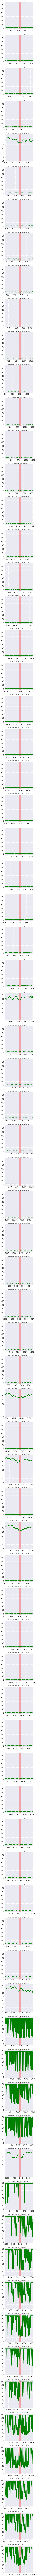

In [18]:
#plotting detected dips

plt.style.use("seaborn")

fig, axs = plt.subplots(len(c1_wide), figsize=(6, 7*len(c1_wide)))
for i in range(len(c1_wide)):
    Title= str('Time:'+c1_wide.iloc[i]['Time'])+'     Met_Length:'+str(c1_wide.iloc[i]['Met_length'])
    #Title= str('Time:'+c1_wide.iloc[i]['Time'])+ str(c1_wide.iloc[i]['Triad'])
    det= int(c1_wide.iloc[i]['Index'])
    
    colors= ['green', 'steelblue', 'purple']
    l_width=[5,7,5]
    l_style=['solid', 'solid', 'dashed']
    #for j in range(3):
    axs[i].plot(df[c1_wide.iloc[i]['Triad']], linewidth=5, color='green', linestyle='solid')
    axs[i].axvspan(det,det+15, facecolor='r', alpha=0.3)
    axs[i].set_title(Title)
    axs[i].tick_params(axis='both', labelsize=18)
    
    axs[i].legend(fontsize=16, loc='center right')
    axs[i].grid(axis = 'both', linestyle='--')
    axs[i].set_xlim(det-100,det+100)
plt.show()
    

In [27]:
#save dip points as csv file

c1_wide.to_csv('dump/bo_result.csv')